# Applying XGBoost to value 2017 NFL Draft Players

In this notebook, I apply a boosted decision trees algorithm to see if we can give a value to players in the draft.

In [69]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import linear_model, ensemble, decomposition, metrics, preprocessing
from sklearn.decomposition import PCA, KernelPCA

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('tableau10')


## 1. Initial data exploration

In [67]:
df = pd.read_csv('/Users/richard/data/NFL/NFL.csv', index_col='idx')
df = df.astype({'Probowl' : 'category', 'School': 'category'})
df = df[df['Pos']!='K']

Check to see if any correlations exist in the data:

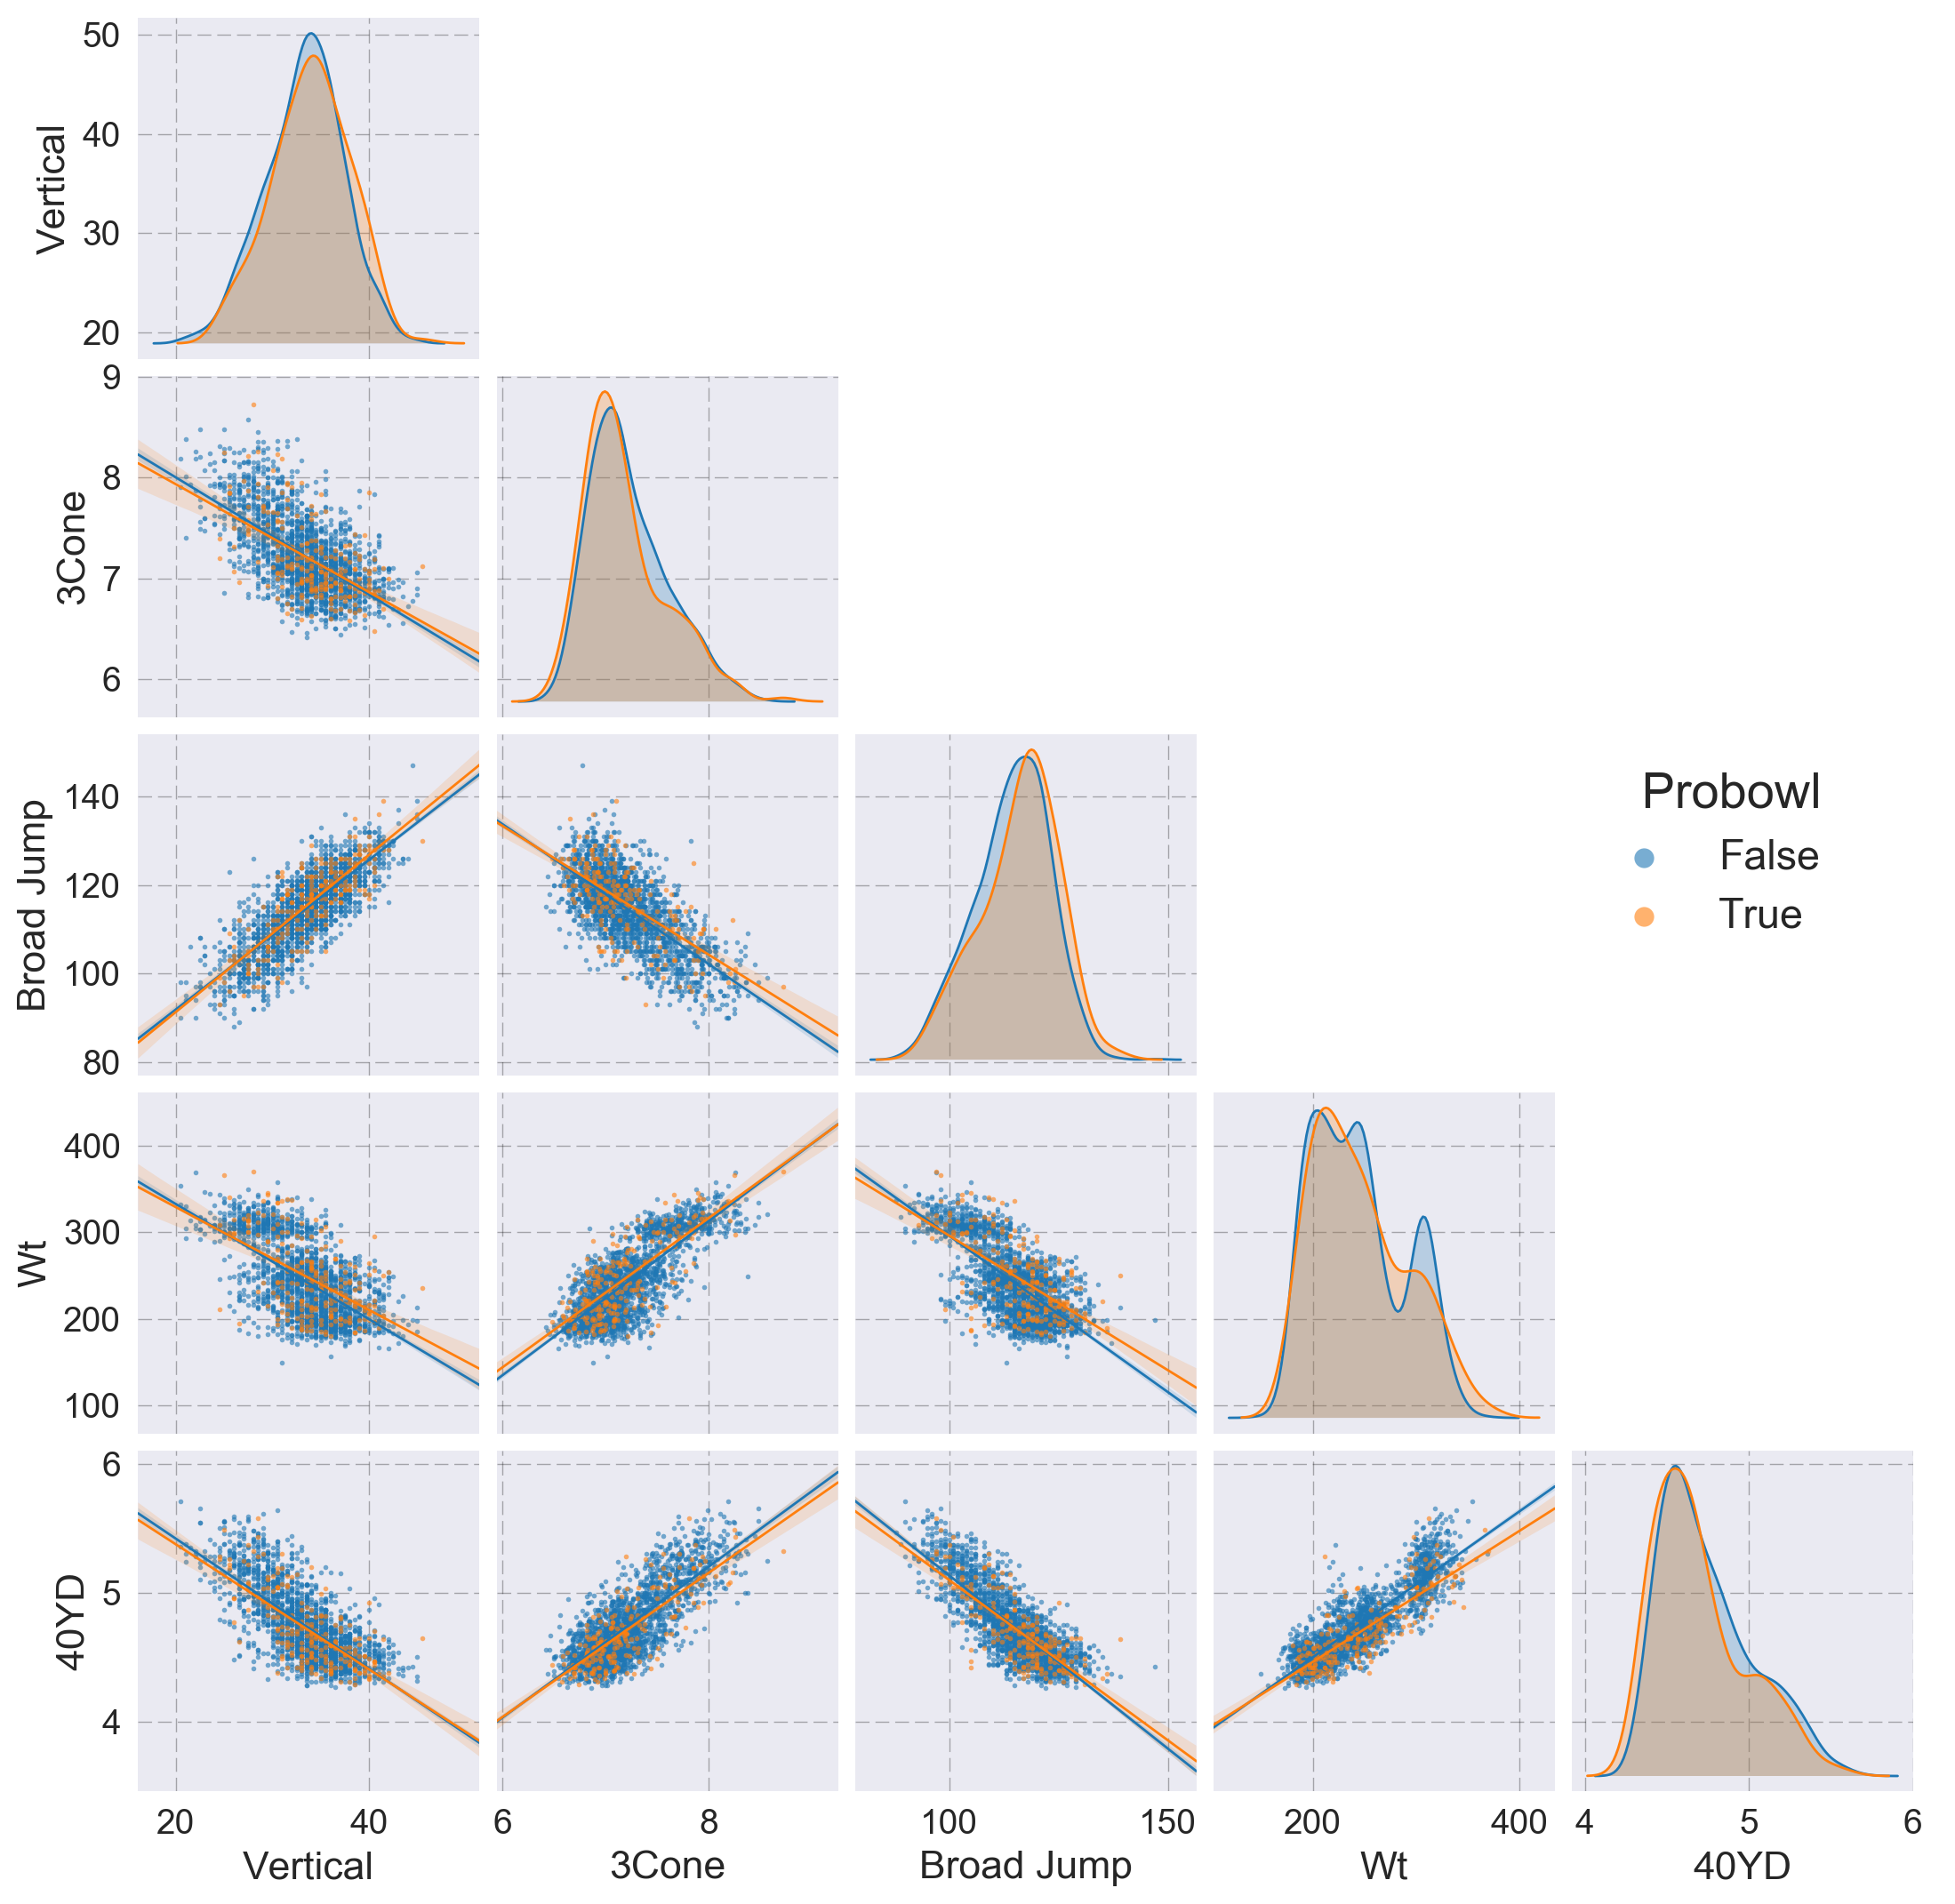

In [31]:
plot_vars = ['Vertical', '3Cone', 'Broad Jump', 'Wt', '40YD']
hue_var   = 'Probowl' 
cols = plot_vars + [hue_var]

data = df[cols].dropna(axis=0)
pair_plot(data, plot_vars, hue_var)
plt.savefig('nfl.pdf')

Does not seem like many, therefore perhaps we wouldn't expect XGBoost to pick up on any patterns. Let's try anyway.

## XGBoost model on combine data

In [21]:
cv_folds              = 5
early_stopping_rounds = 150

features = ['Wt', '40YD', 'Vertical', 'BenchReps', 'Broad Jump', '3Cone', 'Shuttle', 'Height_inches']
target   = 'Probowl' 

X = pd.get_dummies(df[features])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

alg = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.9,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=8,
                    scale_pos_weight=1,
                    silent=True)

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds)

alg.set_params(n_estimators=cvresult.shape[0])
alg.fit(X_train, y_train, eval_metric='auc');

### Feature importance:

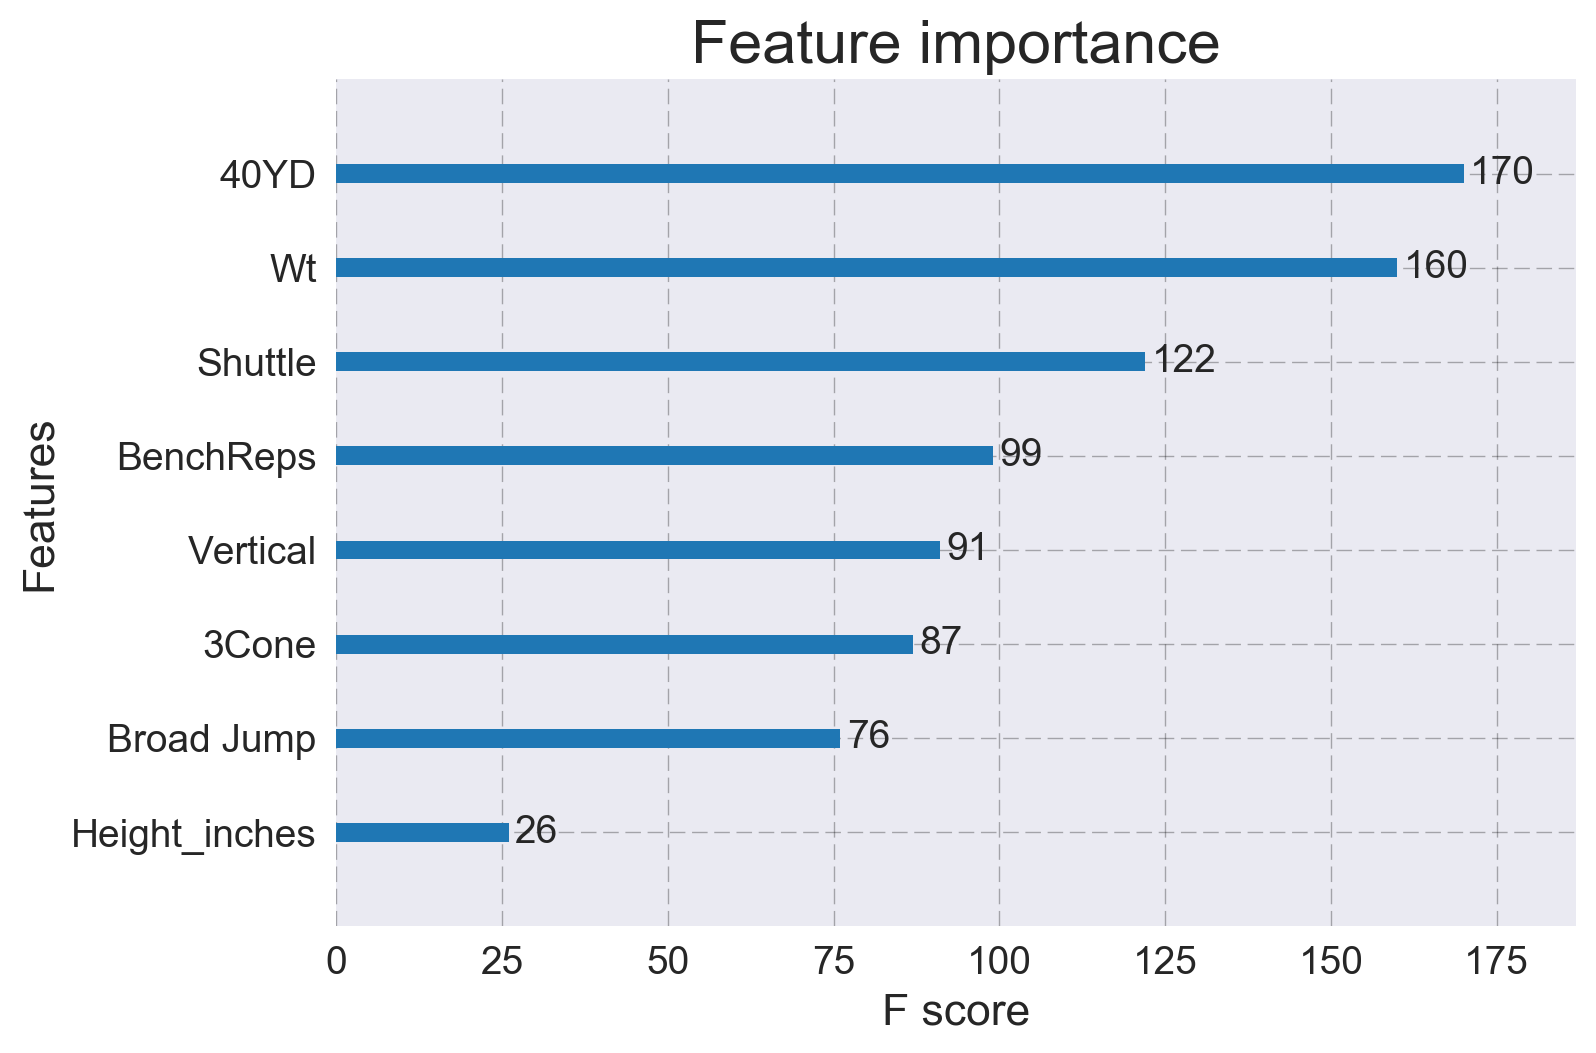

In [68]:
xgb.plot_importance(alg);

In [41]:
pca = PCA(n_components=8)
df2 = df.copy()
df2['Probowl'] = df2['Probowl'].astype(int)
X = df2[features].dropna() 
pca.fit(X)

#Xtrans[y==0,1]
#components = pd.DataFrame(pca.components_,columns=X.columns,index = ['PC-1','PC-2', 'PC-3'])

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

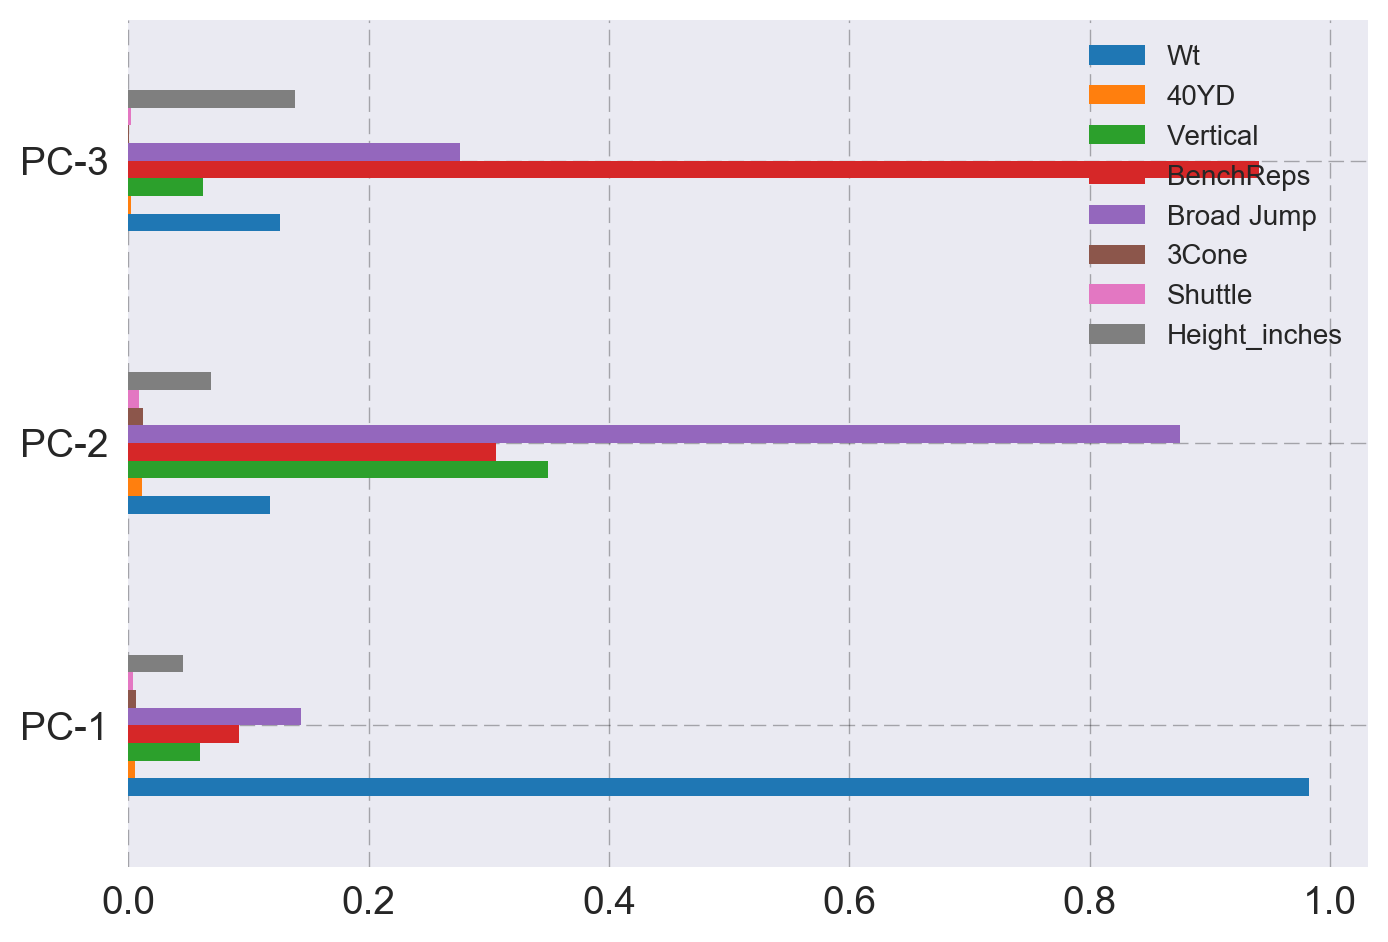

In [38]:
np.abs(components).plot.barh()

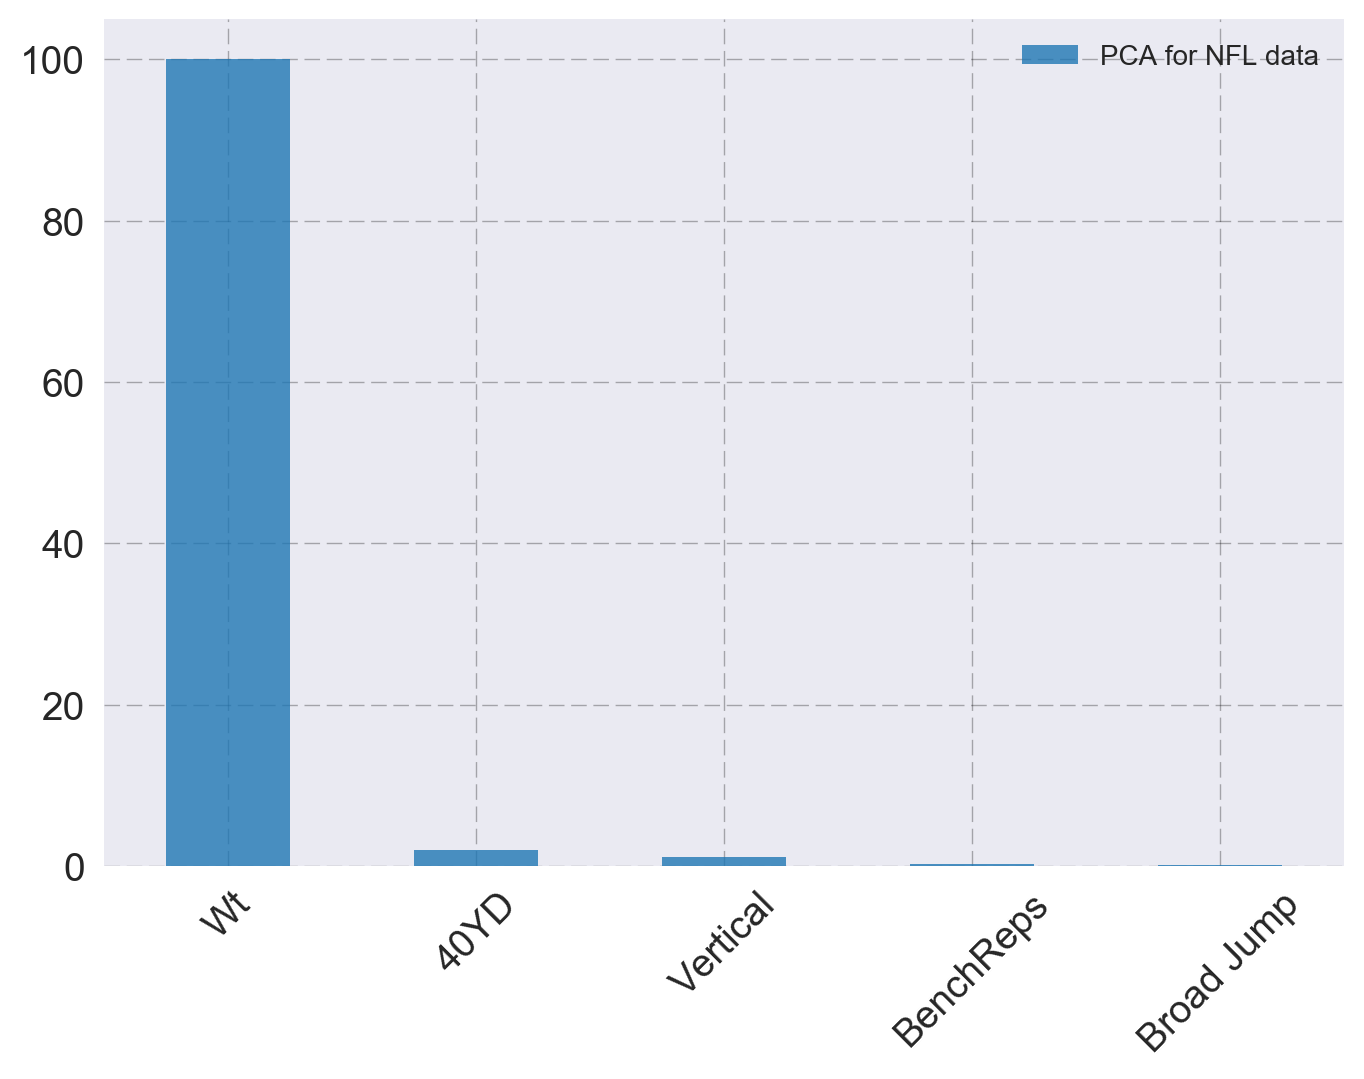

In [65]:
data = pd.Series(pca.explained_variance_, index=features)
(data/data.max()*100).sort_values(ascending=False).head(n=5).plot.bar(rot=45, alpha=0.8, label='PCA for NFL data', legend=True);
plt.savefig('pca_nfl_data.pdf')

## Testing the model's performance


In [27]:
test = pd.concat([df.ix[X_test.index], 
                  pd.Series(alg.predict_proba(X_test)[:,0], index=X_test.index, name='Probability'),
                  pd.Series(alg.predict(X_test), index=X_test.index, name='Prediction')], axis=1)

In [28]:
alg.score(test[features].astype(float), test['Probowl'].astype(float))

0.88596491228070173

In [30]:
m = (metrics.confusion_matrix(test['Probowl'].astype(int), test['Prediction'].astype(int))).astype(float)
#m[0,:] = m[0,:] / m[0,:].sum()
#m[1,:] = m[1,:] / m[1,:].sum()

print(m)


[[ 303.    1.]
 [  38.    0.]]


In [6]:
def pair_plot(data, plot_vars, hue_var):
    g = sns.pairplot(data=data, vars=plot_vars, size=2.2, hue = hue_var, kind='reg', diag_kind='kde',
                     plot_kws={'scatter_kws': {'s': 4, 'alpha': 0.6}, 'line_kws': {'linewidth': 1.0 }},
                     diag_kws={'linewidth': 1.0, 'shade' : True} )

    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    
    g.fig.subplots_adjust(wspace=.05, hspace=.05)

    g._legend.remove()
    
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    legend = g.fig.legend(handles, labels, fontsize='large', loc=(0.81, 0.5), markerscale=4)
    legend.set_title('   {0}'.format(hue_var), prop = {'size':'x-large'})